In [3]:
import scanpy as sc
import numpy as np

import os

In [9]:
def reprocess(adata):
    adata.layers["clean"] = sc.pp.log1p(
            sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)[
                "X"
            ]
        )
    adata.obsm["clean_pca"] = sc.pp.pca(
            adata.layers["clean"],
            n_comps=300 if adata.shape[0] > 300 else adata.shape[0] - 2,
    )
    sc.pp.neighbors(adata, use_rep="clean_pca")
    sc.tl.leiden(adata, key_added="leiden_3", resolution=3.0)
    sc.tl.leiden(adata, key_added="leiden_2", resolution=2.0)
    sc.tl.leiden(adata, key_added="leiden_1", resolution=1.0)
    sc.tl.umap(adata)
    sc.tl.diffmap(adata)
    # create a meta group
    adata.obs["dpt_group"] = (
        adata.obs["leiden_1"].astype(str)
        + "_"
        + adata.obs["disease_ontology_term_id"].astype(str)
        + "_"
        + adata.obs["cell_type_ontology_term_id"].astype(str)
        + "_"
        + adata.obs["tissue_ontology_term_id"].astype(str)
    )  # + "_" + adata.obs['dataset_id'].astype(str)

    # if group is too small
    okgroup = [i for i, j in adata.obs["dpt_group"].value_counts().items() if j >= 10]
    not_okgroup = [i for i, j in adata.obs["dpt_group"].value_counts().items() if j < 3]
    # set the group to empty
    adata.obs.loc[adata.obs["dpt_group"].isin(not_okgroup), "dpt_group"] = ""
    adata.obs["heat_diff"] = np.nan
    # for each group
    for val in set(okgroup):
        if val == "":
            continue
        # get the best root cell
        eq = adata.obs.dpt_group == val
        loc = np.where(eq)[0]

        root_ixs = loc[adata.obsm["X_diffmap"][eq, 0].argmin()]
        adata.uns["iroot"] = root_ixs
        # compute the diffusion pseudo time from it
        sc.tl.dpt(adata)
        adata.obs.loc[eq, "heat_diff"] = adata.obs.loc[eq, "dpt_pseudotime"]
        adata.obs.drop(columns=["dpt_pseudotime"], inplace=True)

    # sort so that the next time points are aligned for all groups
    adata = adata[adata.obs.sort_values(["dpt_group", "heat_diff"]).index]
    return adata

In [4]:
files = os.listdir("/home/ml4ig1/scprint/.lamindb/")

In [5]:
files

['FpAwn0pW8Rbs0z8bm3P6.h5ad',
 'MKqERZsmHrWxKVEDJ55q.h5ad',
 '2JBL0RE2LTYKwTsGI0PL.h5ad',
 'vkvrBqcELUACP5OUGhyY.h5ad',
 'Od1wcPo81WnvaR2Zobi0.h5ad',
 'Uhzgng4Ym452GXFtIOkH.h5ad',
 'WRTwRHRQ8RiKElLM9vQ9.h5ad',
 'EN6VZ53dHxdAoLB6EGf1.h5ad',
 'gwUB8JKWkSX0hDo6ERS4.h5ad',
 '3gOX9hG0jDoCFiSkPkyP.h5ad',
 'z7ZZxORUQFshySbuvNW7.h5ad',
 'f4Aa0ekavQL9WajFE5vZ.h5ad',
 '02qEdLJLQDuDYdvLniWq.h5ad',
 '540UFudpsGb79zzTQNe3.h5ad',
 'geuziJt4iMvYMaF8MgNE.h5ad',
 'G3XfZTjNHPngyl1rZldy.h5ad',
 'DStx6G75Iaa5YA4IEuig.h5ad',
 'QZ9cXGj0iEjSSfhCYfSl.h5ad',
 'atCZlqlsNdcbtJoZAWkL.h5ad',
 'By4OFRRcZVsskHTDQ78p.h5ad',
 'yBCKp6HmXuHa0cZptMo7.h5ad',
 '9aulkb6kNYZpvvFovfDd.h5ad',
 '6exDZlVyR8YYMgAnKTeT.h5ad',
 'pq1t4qxkdhCshteXeFX6.h5ad',
 'nDPECretyJ4q1fC6EbgH.h5ad',
 'rfiWHGtdMsZw8j8GzsVQ.h5ad',
 'xerB76M19gtPocfa1O10.h5ad',
 '6hLF02A15WBM29D1mOIL.h5ad',
 'IXJxFqVWqhPvQARNbaNo.h5ad',
 '6mUW8kidqQCc30K8fTK4.h5ad',
 'Uy9IQKO9U0cxaFrL7hQY.h5ad',
 'rZLBP7jFxujwJxIinhCb.h5ad',
 '2vVHkfADOBU1ZVKmO9tV.h5ad',
 'qweX0bpN

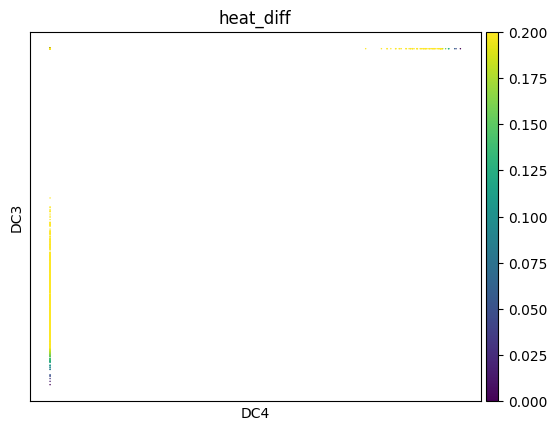

In [15]:
sc.pl.embedding(adata, basis="diffmap", color=['heat_diff'], components=["4,3"], vmax=0.2)

In [21]:
adata.obs[adata.obs.dpt_group.str[0]=="1"].heat_diff.min()

0.0

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


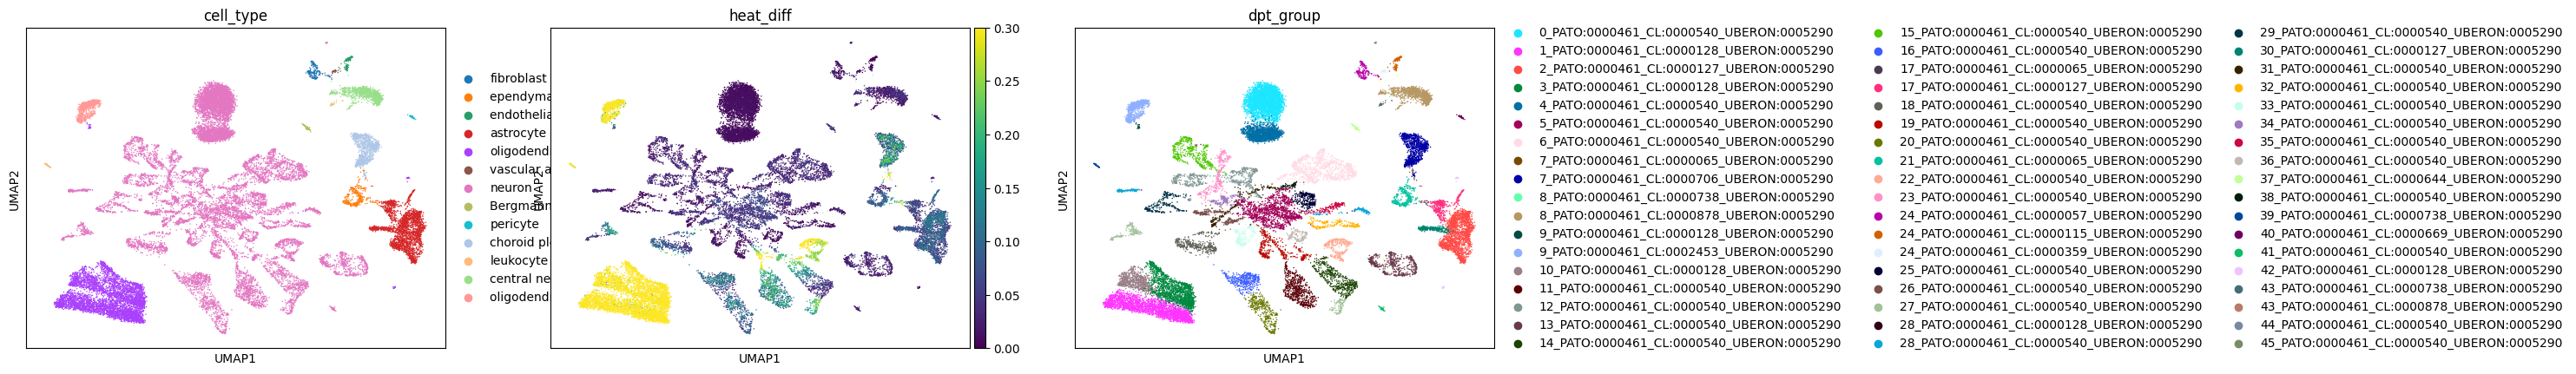

In [17]:
sc.pl.umap(adata, color=["cell_type", "heat_diff", "dpt_group"], vmax=0.3)

In [10]:
adata = reprocess(sc.read_h5ad("/home/ml4ig1/scprint/.lamindb/"+files[1]))

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [8]:
adata

In [ ]:
for f in files:
    adata = reprocess(sc.read_h5ad(f))
    sc.write(f, adata)